# EMPIRICAL TRANSFER FUNCTIONS

## Preliminaries

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.0.5'

## Models

### SIMPLE_MODEL

In [2]:
SIMPLE_MODEL = """
species E1;
J1: S1 -> S2; S1 + E1
S1 = 10; S2 = 0; E1 = 0;
"""

### LINEAR_MODEL

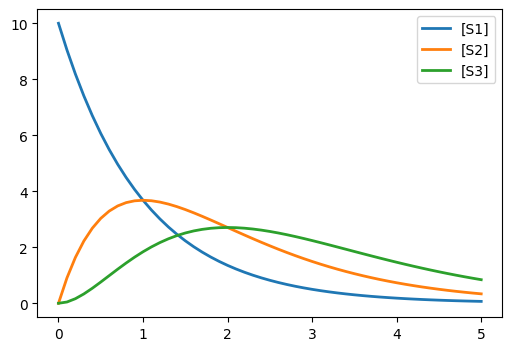

In [3]:
LINEAR_MODEL = """
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot()

In [4]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MODEL, input_names=["S1"], output_names=["S3"])

### WOLF_MODEL

In [5]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["at_"], output_names=["s5"])
print(WOLF_MODEL)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

### MTOR_MODEL

In [6]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["pIR"], output_names=["mTORC1_DEPTOR"])
print(MTOR_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

# Helpers

In [7]:
def plotTimeResponse(time_response, output_names,
                     is_legend=True, stmts=None):
    # Plots the results of running a simulation
    outputs = time_response.outputs
    times = time_response.time
    colors = ["orange", "green"]
    for idx in range(len(output_names)):
        if np.ndim(outputs) > 1:
            plt.plot(times, outputs[idx,:], c=colors[idx])
        else:
            plt.plot(times, outputs, c=colors[idx])
    if is_legend:
        _ = plt.legend(output_names)
    if stmts is None:
        stmts = []
    for stmt in stmts:
        exec(stmt)
    plt.xlabel("time")
    plt.ylabel("concentration")

# Linear model transfer function

In this section, we use LINEAR_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Step 1. Construct the ``SISOTransferFunctionBuilder``

In [8]:
linear_builder = LINEAR_CTLSB.makeSISOTransferFunctionBuilder()
linear_builder.input_name, linear_builder.output_name

('S1', 'S3')

## Step 2. Determine the operating region

The operating region of the range of input values that are being considered.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

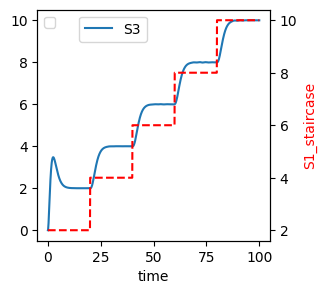

In [9]:
linear_builder.plotStaircaseResponse(initial_value=2, final_value=10, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=100)

## Step 3. Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials.

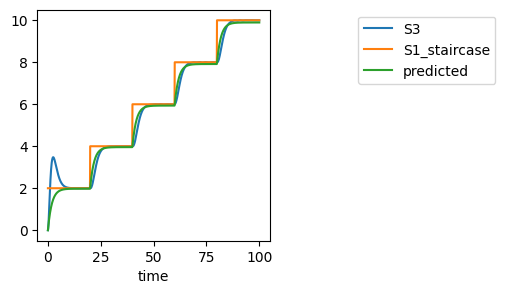

In [10]:
fitter_result = linear_builder.fitTransferFunction(1, 2, final_value=10,
                                                   initial_value=2, end_time=100)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

This plot displays values of ``S3`` in response to values of ``S1``.
We see that the output closely follows the input, and that there is a response over
the entire range of input.

## Step 4. Analyze the fit result

``fitter_result`` has many useful properties.
* ``minimizer_result`` contains detailed information about the results of the optimization
* ``nfev`` is the number of different transfer functions that were evaluated to find the fit
* ``parameters`` contains the parameter values
* ``redchi`` is the reduced ChiSq for the fit
* ``stderr`` contains the standard deviations of the parameter values
* ``time_series`` is a ``Timeseries`` object with the input, nonlinear simulated output, and predicted value of the output
* ``transfer_function`` is the fitted transfer function

In [11]:
fitter_result.transfer_function

TransferFunction(array([5.36750508]), array([9.99978199, 5.42412786]))

In [12]:
fitter_result.nfev

1554


   5.368
------------
10 s + 5.424



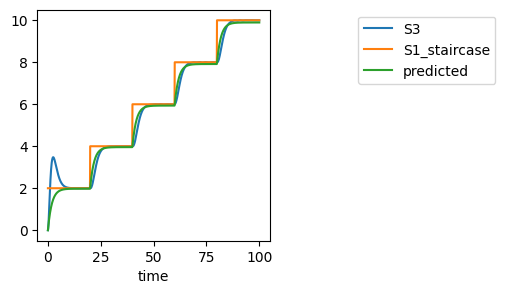

In [13]:
print(fitter_result.transfer_function)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2, 1))

#  Wolf Transfer Function

In [14]:
wolf_builder = WOLF_CTLSB.makeSISOTransferFunctionBuilder()
wolf_builder.input_name, wolf_builder.output_name

('at_', 's5')

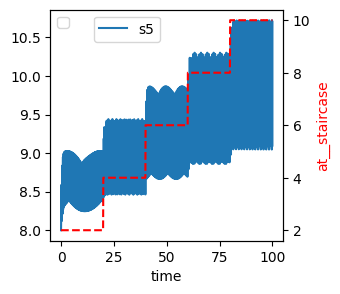

In [15]:
wolf_builder.plotStaircaseResponse(initial_value=2, final_value=10, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=100)


0.6653 s^2 + 0.2873 s + 0.001517
---------------------------------
0.4851 s^2 + 0.04005 s + 0.004102



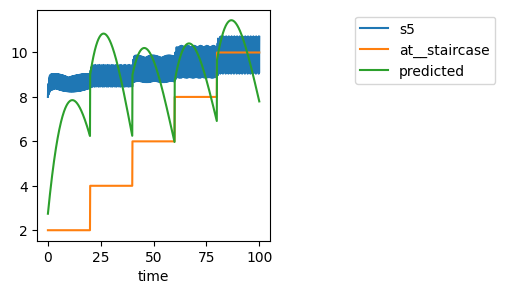

In [16]:
fitter_result = wolf_builder.fitTransferFunction(3, 3, final_value=10,
                                                   initial_value=2, end_time=100)
print(fitter_result.transfer_function)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2, 1))

In [18]:
fitter_result.transfer_function.dcgain()

0.369852609941328

Is this model sufficiently accurate to do control design?

The key consideration here is accuracy of DC Gain. How do the step increases in input relate to the magnitude of the increase in output?

# mTOR transfer function

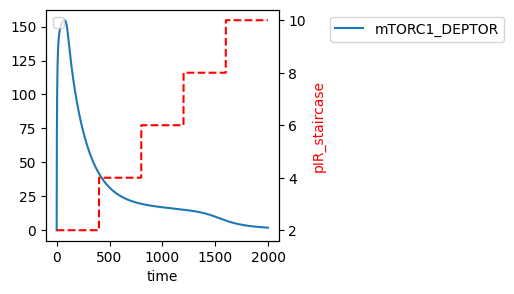

In [17]:
mtor_builder = MTOR_CTLSB.makeSISOTransferFunctionBuilder()
mtor_builder.plotStaircaseResponse(initial_value=2, final_value=10, figsize=(3,3),
                                    legend_crd=(2, 1), end_time=2000)

There does not seem to be a relationship between the step input and the output.